# ACTA 2. Limpieza y Análisis exploratorio de los datos. Parte 1

En esta entrega se pretende realizar un primer análisis exploratorio de nuestro conjunto de datos descargado en Acta 1. ...... para realizar una limpieza que asegure que nuestros datos son una base correcta para la creación de un modelo predictivo correcto. 

## Índice
- [Importación de librerías](#Importación-de-librerías)
- [Exploración del conjunto de datos](#Exploración-del-conjunto-de-datos)
- [Análisis exploratorio](#Análisis-exploratorio)
    - [Variables datetime](#Análisis-exploratorio#Variables-datetime)
    - [Variables numéricas](#Análisis-exploratorio#Variables-numéricas)
    - [Variables categóricas](#Análisis-exploratorio#Variables-categóricas)
- [Análisis valores faltantes](#Análisis-valores-faltantes)

### Importación de librerías<a name="Importación-de-librerías"></a>

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import geopandas as gpd
import seaborn as sns
from geopy import Point as GeoPyPoint
from shapely.geometry import Point, Polygon
from shapely.geometry import shape, Point, MultiPolygon
import json
from joblib import Parallel, delayed


## Exploración del conjunto de datos<a name="Exploración-del-conjunto-de-datos"></a>

Mostramos las variables de nuestro conjunto de datos, ordenando por la fecha del incidente

In [2]:
sfIncidents = pd.read_csv('SFIncidents.csv',delimiter=',')
sfIncidents_s = sfIncidents.sort_values(by='incident_date')
sfIncidents_s.columns

Index(['incident_datetime', 'incident_date', 'incident_time', 'incident_year',
       'incident_day_of_week', 'report_datetime', 'row_id', 'incident_id',
       'incident_number', 'report_type_code', 'report_type_description',
       'incident_code', 'incident_category', 'incident_subcategory',
       'incident_description', 'resolution', 'police_district', 'filed_online',
       'cad_number', 'intersection', 'cnn', 'analysis_neighborhood',
       'supervisor_district', 'supervisor_district_2012', 'latitude',
       'longitude', 'point'],
      dtype='object')

Este conjunto de datos de incidentes de San Francisco contiene información sobre los incidentes registrados en San Francisco desde 2003 hasta la fecha. 
La descripción de estas variables es:

- 'incident_datetime': Fecha y hora en que ocurrió el incidente.
- 'incident_date': Fecha en que ocurrió el incidente.
- 'incident_time': Hora en que ocurrió el incidente.
- 'incident_year': Año en que ocurrió el incidente.
- 'incident_day_of_week': Día de la semana en que ocurrió el incidente.
- 'report_datetime': Fecha y hora en que se realizó el informe del incidente.
- 'row_id': Identificador único del incidente.
- 'incident_id': Identificador único del incidente.
- 'incident_number': Número del incidente.
- 'report_type_code': Código del tipo de informe del incidente.
- 'report_type_description': Descripción del tipo de informe del incidente.
- 'incident_code': Código del incidente.
- 'incident_category': Categoría del incidente.
- 'incident_subcategory': Subcategoría del incidente.
- 'incident_description': Descripción del incidente.
- 'resolution': Resolución del incidente.
- 'police_district': Distrito de policía en el que ocurrió el incidente.
- 'filed_online': Indicador de si el informe fue presentado en línea.
- 'cad_number': Número del sistema de despacho de la policía.
- 'intersection': Intersección donde ocurrió el incidente.
- 'cnn': Número de identificación de la calle.
- 'analysis_neighborhood': Barrio donde ocurrió el incidente.
- 'supervisor_district': Distrito de supervisión en el que ocurrió el incidente.
- 'supervisor_district_2012': Distrito de supervisión en el que ocurrió el incidente (2012).
- 'latitude': Latitud de la ubicación del incidente.
- 'longitude': Longitud de la ubicación del incidente.
- 'point': Coordenadas de la ubicación del incidente (latitud y longitud).

Vamos a ver la dimensión del conjunto de datos original

In [3]:
sfIncidents_s.shape

(717040, 27)

Tenemos un conjunto de 717040 registros o filas y 27 variables o columnas, de estas 27 variables vamos a quedarnos con las variables de nuestro interés. 

- Hay varias variables que hacen referencia a la fecha y tenemos información redundante, estas variables son: 'incident_datetime', 'incident_date', 'incident_time', 'incident_year', 'incident_day_of_week' y 'report_datetime'. De estas variables nos quedaremos con las variables 'incident_datetime' y 'incident_day_of_week', estas nos indicarán en los valores predichos el horario real del incidente y el día de la semana. El resto son información redundante. 
- La variable 'report_datetime' será eliminada porque indica la fecha y hora en la que se notificó a los cuerpos de seguridad sobre el incidente, en nuestro caso queremos predecir el momento y lugar del incidente no el momento en el que se reporta el incidente. La intención es predecir el incidente y anticiparse a los acontecimientos. 
- Las variables 'police_district' y 'analysis_neighborhood' debido a que nos muestran información geográfica y a que no estamos seguros de que los distritos policiales y los vecindarios hayan sido los mismos durante todo el periodo que engloba el conjunto de datos. Estas dos variables serán calculadas posteriormente mediante código Python a partir de dos conjuntos de datos presentes en la plataforma OpenDataSF en los que tenemos las latitudes y longitudes que definen tanto los distritos policiales como los vecindarios. De esta forma nos aseguraremos de que los vecindarios y los distritos policiales sean los válidos actualmente por el Departamento de policía de San Francisco y así en las predicciones también tenemos los datos correctos. 
- Las variables 'row_id', 'incident_id', 'incident_number' ya que nos aportan solo información de identificación del incidente y no es información relevante para nuestro estudio. 
- La variable 'filed_online' ya que no es de nuestro interés predecir si el incidente fue reportado de forma online. 
- La variable 'cad_number', no interesa predecir el número del sistema de despacho de policía.
- La variable 'intersection' y 'cnn', aportan información relevante a la latitud y a la longitud. Además no tenemos información sobre el número de calle que define a cada calle por lo que posteriormente en el preprocesado calcularemos la dirección y la calle correspondientes a la latitud y a la longitud por medio de la librería Geopy de Python. 
- Las variables 'supervisor_district' y 'supervisor_district_2012' porque son información redundante entre sí y con la variable distrito policial que ya ha sido seleccionada como variable de interés.
- La variable 'point' debido a que es una tupla calculada a partir de la unión de la latitud y de la longitud. 
- Las variables 'report_type_code' y 'report_type_description' ya que proporcionan información sobre el tipo de informe realizado para un incidente, esto abarca información no relevante para nuestro futuro modelo predictivo. 

Una vez hemos decidido que variables son de nuestro interés, procedemos a seleccionarlas y crear un conjunto de datos a partir de ellas.

In [4]:
variables = ['incident_datetime', 'incident_description', 'resolution','incident_day_of_week','incident_code', 'incident_category', 'incident_subcategory', 'latitude','longitude']
drop_columns = [col for col in sfIncidents_s.columns if col not in variables]
sfIncidents_s = sfIncidents_s.drop(columns=drop_columns)

Mostramos las dimensiones de nuestro dataset resultante de haber eliminado las variables que no son de nuestro interés

In [5]:
sfIncidents_s.shape

(717040, 9)

Finalmente tenemos un conjunto de datos con 717040 registros y 9 variables. 
A continuación empezaremos con el análisis exploratorio de nuestros datos. 
Comenzaremos mostrando nuestros primeros 5 registros por contemplar los datos que tenemos y el formato.

In [6]:
sfIncidents_s.head()

,incident_datetime,incident_day_of_week,incident_code,incident_category,incident_subcategory,incident_description,resolution,latitude,longitude
331979,2018-01-01T01:30:00.000,Monday,71000,Lost Property,Lost Property,Lost Property,Open or Active,37.788721,-122.402066
409961,2018-01-01T00:00:00.000,Monday,68030,Courtesy Report,Courtesy Report,Courtesy Report,Open or Active,37.798442,-122.409879
300636,2018-01-01T17:00:00.000,Monday,9029,Fraud,Fraud,False Personation to Receive Money or Property,Open or Active,37.754736,-122.507674
408659,2018-01-01T12:00:00.000,Monday,71013,Larceny Theft,Theft From Vehicle,"License Plate, Stolen",Open or Active,37.737318,-122.447810
332816,2018-01-01T16:00:00.000,Monday,6304,Larceny Theft,Larceny Theft - From Building,"Theft, From Building, >$950",Open or Active,37.764664,-122.404497


Observamos que tenemos información que representa el momento del incidente, la ubicación exacta por medio de la latitud y la longitud y variables que identifican y describen al incidente

Vamos a visualizar un resumen de las variables

In [7]:
sfIncidents_s.info()

<class 'pandas.core.frame.DataFrame'>
Index: 717040 entries, 331979 to 9913
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   incident_datetime     717040 non-null  object 
 1   incident_day_of_week  717040 non-null  object 
 2   incident_code         717040 non-null  int64  
 3   incident_category     716424 non-null  object 
 4   incident_subcategory  716424 non-null  object 
 5   incident_description  717040 non-null  object 
 6   resolution            717040 non-null  object 
 7   latitude              678848 non-null  float64
 8   longitude             678848 non-null  float64
dtypes: float64(2), int64(1), object(6)
memory usage: 54.7+ MB


Vemos que únicamente la latitud y la longitud e incidente_code, son variables de tipo numérico. El resto son variables de tipo objeto.

Ahora mostraremos las estadísticas descriptivas de estas variables. 

In [8]:
sfIncidents_s.describe()

,incident_code,latitude,longitude
count,717040.000000,678848.000000,678848.000000
mean,24569.369967,37.769203,-122.423957
std,25633.373116,0.024477,0.026381
min,1000.000000,37.707988,-122.511295
25%,6244.000000,37.754692,-122.434483
50%,7041.000000,37.775834,-122.417716
75%,51040.000000,37.785829,-122.407323
max,75030.000000,37.829991,-122.363743


Observamos que no tiene sentido que la variabla incident_code sea numérica ya que es una variable categórica codificada. 

En cuanto a la latitud y la longitud serán analizadas posteriormente con más detalle. 

Convertiremos las variable numérica, incident_code a tipo categórica para poder analizarla posteriormente junto a las variables categóricas y además convierto las variables de tipo objeto a categóricas. 

In [9]:
sfIncidents_s['incident_code'] = sfIncidents_s['incident_code'].astype('category')
obj_cols = sfIncidents_s.drop(columns=['incident_datetime']).select_dtypes(include=['object']).columns
sfIncidents_s[obj_cols] = sfIncidents_s[obj_cols].astype('category')

## Análisis exploratorio<a name="Análisis-exploratorio"></a>

### Variables datetime<a name="Variables-datetime"></a>

A continuación realizaremos un análisis exploratorio fecha para incident_datetime y day_of_week. 

In [10]:
sfIncidents_s['incident_datetime'] = pd.to_datetime(sfIncidents_s['incident_datetime'])
print('Valor mínimo: ' + str(sfIncidents_s['incident_datetime'].min()))
print('Valor máximo: ' + str(sfIncidents_s['incident_datetime'].max()))

Valor mínimo: 2018-01-01 00:00:00
Valor máximo: 2023-04-11 22:39:00


Como vemos tenemos datos desde 2018 hasta abril de 2023, Vamos a hacer un recuento de registros por año para visualizar la proporción de registros por año. 

In [11]:
print(sfIncidents_s['incident_datetime'].dt.year.value_counts().sort_index())


incident_datetime
2018    152702
2019    148255
2020    118284
2021    128741
2022    134502
2023     34556
Name: count, dtype: int64


Observamos que el año con más registros es 2018 y el año con menos incidentes es 2020. No tenemos en cuenta el año 2023 porque sólo tenemos registros hasta abril.

Con el objetivo de estudiar la hora vamos a visualizar la distribución de la hora de los incidentes

In [12]:
print('Valor mínimo de la hora: ' + str(sfIncidents_s['incident_datetime'].dt.hour.min()))
print('Valor máximo de la hora: ' + str(sfIncidents_s['incident_datetime'].dt.hour.max()))

Valor mínimo de la hora: 0
Valor máximo de la hora: 23


<Axes: xlabel='incident_datetime'>

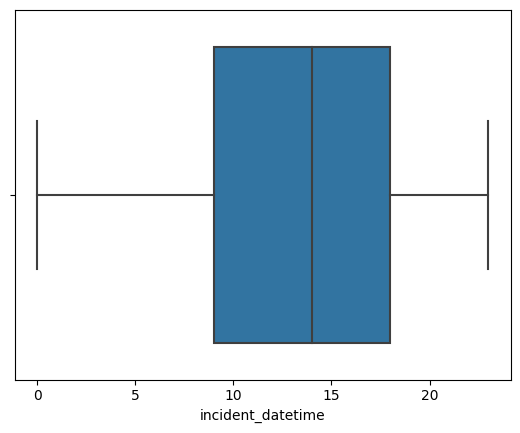

In [13]:
sns.boxplot(x= sfIncidents_s['incident_datetime'].dt.hour)

En el gráfico anterior contemplamos que las horas en las que más se suelen producir incidentes están entre las 9 y 18 horas. 
Por otro lado vemos que la hora en la que más se han producido los incidentes son las 14 horas.


Realizamos un histograma para visualizar mejor la distribución que en el gráfico boxplot realizado anteriormente. 

<Axes: xlabel='incident_datetime', ylabel='Count'>

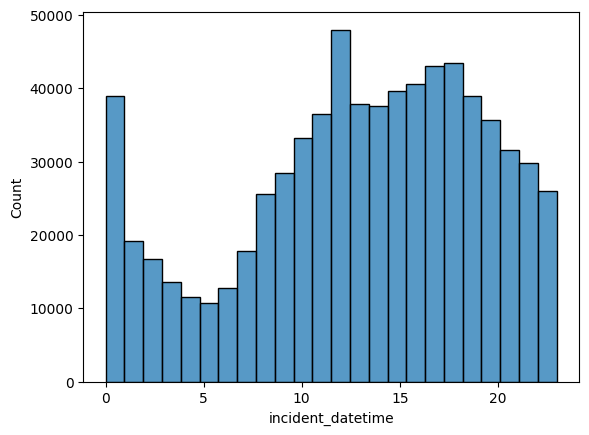

In [14]:
sns.histplot(data=sfIncidents_s, x=sfIncidents_s['incident_datetime'].dt.hour, bins=24)

Contemplamos que las horas en las que más ha habido incidentes se producen a primera hora de la madrugada, a medidodía y a principios de la tarde. 
Las horas más presentes en nuestros datos son: 00, 12, 15, 16, 17 y 18. 

Ahora pasamos a analizar la variables 'incident_day_of_week'. Hacemos un recuento de valores.

In [15]:
print(sfIncidents_s['incident_day_of_week'].value_counts())

incident_day_of_week
Friday       109827
Wednesday    106430
Thursday     102452
Monday       101513
Saturday     101283
Tuesday      100969
Sunday        94566
Name: count, dtype: int64


Observamos que el día en el que más incidentes se han producido es el viernes. Parece que el día en el que menos incidentes de producen es domingo. 

Mostramos un histograma para verlo de forma más visual. 

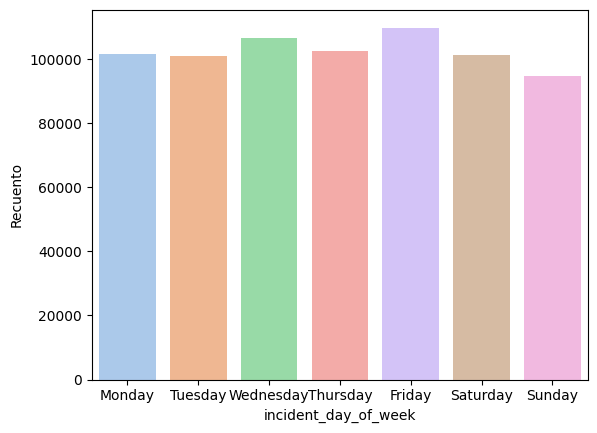

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_palette("pastel")


order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(x=sfIncidents_s['incident_day_of_week'], order=order)


plt.ylabel("Recuento")


plt.show()


Podemos ver en este gráfico anterior que no hay mucha diferencia entre el recuento de cada uno de los días de la semana. Destacaríamos como días en los que más incidentes se producen el viernes y miércoles.

### Variables numéricas<a name="Variables-numéricas"></a>

In [17]:
sfIncidents_s.describe()

,incident_datetime,latitude,longitude
count,717040,678848.000000,678848.000000
mean,2020-07-21 07:55:26.178288640,37.769203,-122.423957
min,2018-01-01 00:00:00,37.707988,-122.511295
25%,2019-03-10 14:00:00,37.754692,-122.434483
50%,2020-06-23 20:30:00,37.775834,-122.417716
75%,2021-12-03 10:00:00,37.785829,-122.407323
max,2023-04-11 22:39:00,37.829991,-122.363743
std,NaN,0.024477,0.026381


Para analizar la latitud y la longitud, lo que haremos será revisar si todos los puntos geográficos de nuestro conjunto de datos pertenecen a San Francisco.
Para ello emplearemos el conjunto de datos publicado por el Departamento de Planificación de San Francisco en la plataforma OpenData, en el que se encuentran las coordenadas geográficas de todas las ciudades pertenecientes al Área de la Bahía de San Francisco, por tanto tendremos que filtrar por el condado de San Francisco. https://data.sfgov.org/Geographic-Locations-and-Boundaries/Bay-Area-Counties/s9wg-vcph

Crearemos una función que nos ayude a calcular la columna 'San Francisco' que nos indicará si las coordenadas pertenecen a la ciudad de San Francisco del conjunto de datos descargado o no. Para ello si las coordenadas se encuentran en el polígono definido por el dataset anterior filtrado por el condado de San Francisco, significa que el registro pertenece a San Francisco y devolverá el valor 'Yes' sino devolverá 'No'. También evaluará  si las coordenadas no son válidas, es decir, si tenemos valores de latitud y longitud anómalos, si son inválidos devolverá 'Invalid'. 

El conjunto de datos empleado en este apartado lo descargaremos en dos formatos: csv, para mostrar las 5 primeras líneas y ver el formato de nuestros datos y en formato geojson porque nps permitirá manejar de forma más amigable los distintos polígonos que forman San Francisco. El código de descarga de este csv se puede ver en el documento "ACTA 1. Obtención y extracción de los datos"


In [18]:
bayarea_county = pd.read_csv('bayarea_county.csv')
bayarea_county.head()

,the_geom,OBJECTID,FIPSSTCO,COUNTY
0,MULTIPOLYGON (((-122.2149610020791 37.76112899...,1,6001,Alameda
1,MULTIPOLYGON (((-121.95091100245604 38.0539180...,2,6013,Contra Costa
2,MULTIPOLYGON (((-122.86958900340855 38.0214029...,3,6041,Marin
3,MULTIPOLYGON (((-122.20246200543151 38.6889759...,4,6055,Napa
4,MULTIPOLYGON (((-122.4773830027518 37.81102799...,5,6075,San Francisco


La columna 'the_geom' contiene todos los polígonos que definen cada ciudad, el objetivo es usar la librería shapely para crear un objeto Multypoligon a partir de todos los polígonos que definen el área de San Francisco, ya que este objeto tiene una función que nos permite saber si un punto geográfico pertenece a los distintos polígonos que le proporcionemos. 

De esta forma con una línea de código podemos verificar si un punto geográfico de nuestro registro pertence a San Francisco. 

A continuación cargamos los datos descargados en formato geojson y filtraremos la fila que pertenece a San Francisco. 

In [19]:
gdf = gpd.read_file("Bay Area Counties.geojson")

sf_gdf = gdf[gdf["county"] == "San Francisco"]

print(sf_gdf)

          county fipsstco objectid   
4  San Francisco    06075        5  \

                                            geometry  
4  MULTIPOLYGON (((-122.47738 37.81103, -122.4763...  


Ahora crearemos un objeto MultiPolygon a partir de los datos en el campo geometry.

In [20]:
multipolygon = MultiPolygon(sf_gdf['geometry'].iloc[0])

print(multipolygon)

MULTIPOLYGON (((-122.4773830027518 37.8110279985324, -122.47638299914844 37.810827999509335, -122.4759830013289 37.809727998200174, -122.4716250028432 37.80888699769438, -122.47028300451245 37.808627998875025, -122.46779299919203 37.80680899858057, -122.46768300135908 37.8067279974676, -122.46575100100827 37.80568799892819, -122.46378300203135 37.80462799989076, -122.4542820032217 37.80632799891723, -122.45348200072374 37.80652799950531, -122.44828200078767 37.80732800140436, -122.4470820015151 37.807428001332454, -122.4460820014932 37.80762799774489, -122.44528200371676 37.80762799953789, -122.44378200243108 37.80782799805509, -122.44378200251181 37.80766799854344, -122.4437820034566 37.807527999295765, -122.44738200200705 37.80632799796006, -122.44708199997392 37.80542799865116, -122.4425820018721 37.806027999575576, -122.44268200256738 37.806527999340844, -122.44388200245132 37.80642800005626, -122.44269200115872 37.80676800008563, -122.44248200427785 37.80682799876855, -122.4428820

Creamos nuestra función para que nos indique si un registro pertenece a San Francisco. 

In [21]:
def is_in_sf(latitude, longitude):
    if pd.isna(longitude) or pd.isna(latitude):
        return np.nan
    try:
        point = Point(float(longitude), float(latitude))
        if multipolygon.contains(point):
            return "Yes"
        else:
            return "No"
    except:
        return "Invalid"


Aplicamos nuestra función a nuestro conjunto de datos. 

In [22]:
sfIncidents_s['San Francisco'] = sfIncidents_s.apply(lambda row: is_in_sf(row['latitude'], row['longitude']), axis=1)

Vamos a ver si tenemos puntos fuera de San Francisco mostrando un recuento de los distintos valores de esta variable.

In [23]:
sfIncidents_s['San Francisco'].value_counts()

San Francisco
Yes    678728
No        120
Name: count, dtype: int64

Vemos que hay 120 registros que no pertenecen a San Francisco. A continuación analizaremos si estos casos  pertenecen a algún ditrito policial, si no pertenecen a ningún ditrito policial procederemos a eliminarlos ya que nos interesa predecir los incidentes que pertenecen a San Francisco o a algún distrito policial de este condado.

Comprobamos que no pertenezca a ningún distrito policial porque hay zonas, por ejemplo descampados que no pertenecen a ningún condado pero que son asignados al distrito policial más cercano para incluir la zona en el recorrido de patrullaje. 

Para ello emplearemos el conjunto de datos de distritos policiales descargado en el documento "ACTA 1. Obtención y extracción de los datos"
Definiremos una función que nos devuelva si pertenece el punto a algún distrito policial. 

In [24]:
districts = pd.read_csv('sfpd_districts.csv')
districts.head()

,COMPANY,the_geom,Shape_Leng,DISTRICT,Shape_Le_1,Shape_Area
0,B,MULTIPOLYGON (((-122.39186138812263 37.7942468...,87550.275142,SOUTHERN,100231.353916,9.134414e+07
1,C,MULTIPOLYGON (((-122.38098281360058 37.7648002...,163013.798332,BAYVIEW,144143.480351,2.013846e+08
2,D,MULTIPOLYGON (((-122.40953917435229 37.7693177...,40152.783389,MISSION,40518.834235,8.062384e+07
3,E,MULTIPOLYGON (((-122.43379217152915 37.8079301...,56493.858208,NORTHERN,50608.310321,8.278169e+07
4,J,MULTIPOLYGON (((-122.40217133081705 37.7862601...,12424.268969,TENDERLOIN,18796.784185,1.107215e+07


En la función al realizar la primera ejecución requería de mucho tiempo por lo que recurrimos a aplicar técnicas de paralelización mediante la librería Parallel usando todos los recursos computacionales disponibles y así emplear durante la ejecución todos los hilos disponibles del procesador.

In [25]:


def is_in_district_parallel(latitude, longitude, districts):
    point = Point(longitude, latitude)
    for district in districts:
        try:
            polygon = shape(district)
            if point.within(polygon):
                return True
        except:
            pass
    return False


def process_row(row, districts):
    return is_in_district_parallel(row['latitude'], row['longitude'], districts)

sfIncidents_s['En distrito policial'] = Parallel(n_jobs=-1)(delayed(process_row)(row, districts) for idx, row in sfIncidents_s.iterrows())


Revisamos los resultados de nuestra función mostrando los diferentes valores que toma la columna creada para aquellos casos en los que el registro no pertenece a San Francisco. 

In [26]:
sf_no = sfIncidents_s[sfIncidents_s['San Francisco'] == 'No']
sf_no['En distrito policial'].value_counts()

En distrito policial
False    120
Name: count, dtype: int64

Observamos que los 120 casos en los que las coordenadas geográficas no pertenecen a San Francisco  tampoco pertenecen a ningún distrito policial, por ello procederemos a eliminar estos casos ya que nuestro objetivo es predecir incidentes que ocurran dentro de San Francisco en los diferentes distritos policiales. Vamos a considerar estos casos como casos anómalos. 

La justificación de esta eliminación se basa en que el objetivo principal de este proyecto es predecir los incidentes que ocurran en San Francisco y estos puntos no pertenecen a San Francisco por lo que no deberíamos emplearlos para entrenar nuestro modelo. 
Hemos intentado averiguar si estos puntos geográficos pertenecían a alguna zona que no pertenece a San Francisco y que debe ser controlada por la estación de policía de algún ditrito policial y hemos encontrado que no.
Debido a que nuestro conjunto de datos es muy grande procedemos a eliminar estos registros y las columnas calculadas en este apartado. 

In [27]:
drop_row = sfIncidents_s[(sfIncidents_s['San Francisco'] == 'No') & (sfIncidents_s['En distrito policial'] == False)]
sfIncidents_s = sfIncidents_s.drop(drop_row.index)

Eliminamos también las columnas que hemos creado para realizar el estudio anterior. 

In [28]:
drop_col = [ 'San Francisco','En distrito policial']
sfIncidents_s = sfIncidents_s.drop(columns=drop_col)

### Variables categóricas<a name="Variables-categóricas"></a>

Análisis variables categóricas

Para comenzar a analizar estas variables categóricas primero mostramos un listado de todas las variables categóricas.

In [29]:
list(sfIncidents_s.select_dtypes(include=['category']).columns)


['incident_day_of_week',
 'incident_code',
 'incident_category',
 'incident_subcategory',
 'incident_description',
 'resolution']


Como vemos tenemos 6 variables categóricas de las cuales, la variable incident_day_of_week ya ha sido explorada. 
A continuación diviremos este análisis exploratorio de variables categóricas en 3 partes:
1. Análisis de incident_code, incident_category e incident_subcategory ya que son variables relacionadas
2. Análisis de la variable incident_description 
3. Análisis de la variable resolution

1. Incident_code, incident_category, incident_subcategory

En primer lugar para analizar estas variables haremos un recuento por cada una de estas variables

Incident_code

In [30]:
print(sfIncidents_s['incident_code'].value_counts())

incident_code
6244     90769
28150    23844
4134     21176
71000    20827
7041     20310
         ...  
30160        1
6397         1
30131        1
30110        1
6354         1
Name: count, Length: 842, dtype: int64


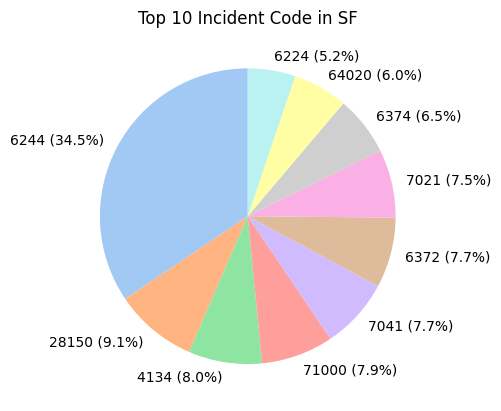

In [31]:


top10 = sfIncidents_s['incident_code'].value_counts().head(10)


colors = sns.color_palette("pastel")

labels = ['{} ({:.1f}%)'.format(label, percentage) for label, percentage in zip(top10.index, top10.values / top10.sum() * 100)]

plt.pie(top10, labels=labels, colors=colors, startangle=90)


plt.title('Top 10 Incident Code in SF')


plt.show()


Incident_category

In [32]:
print(sfIncidents_s['incident_category'].value_counts())

incident_category
Larceny Theft                                   218692
Other Miscellaneous                              49901
Malicious Mischief                               48508
Assault                                          43619
Non-Criminal                                     42621
Burglary                                         40245
Motor Vehicle Theft                              36700
Recovered Vehicle                                27899
Fraud                                            23010
Lost Property                                    20827
Warrant                                          20718
Drug Offense                                     17612
Robbery                                          16001
Missing Person                                   15463
Suspicious Occ                                   14659
Disorderly Conduct                               11782
Offences Against The Family And Children          9864
Miscellaneous Investigation                    

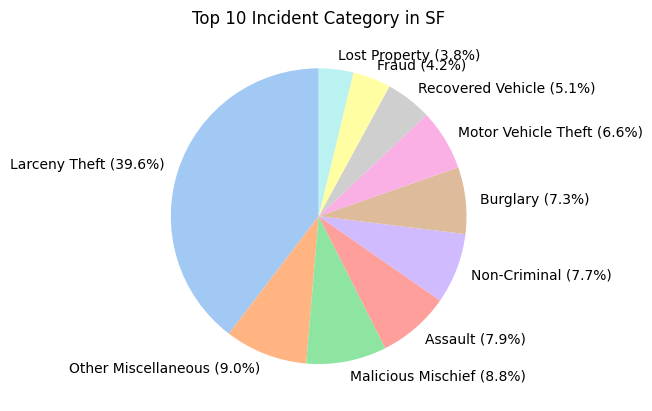

In [33]:

top10 = sfIncidents_s['incident_category'].value_counts().head(10)


colors = sns.color_palette("pastel")

labels = ['{} ({:.1f}%)'.format(label, percentage) for label, percentage in zip(top10.index, top10.values / top10.sum() * 100)]

plt.pie(top10, labels=labels, colors=colors, startangle=90)


plt.title('Top 10 Incident Category in SF')


plt.show()


Incident_subcategory

In [34]:
print(sfIncidents_s['incident_subcategory'].value_counts())

incident_subcategory
Larceny - From Vehicle                      124055
Other                                        88823
Larceny Theft - Other                        50386
Vandalism                                    48175
Motor Vehicle Theft                          36113
                                             ...  
Robbery - Residential                           25
Bribery                                          7
Arrest                                           6
Homicide - Excusable                             1
Human Trafficking, Involuntary Servitude         1
Name: count, Length: 72, dtype: int64


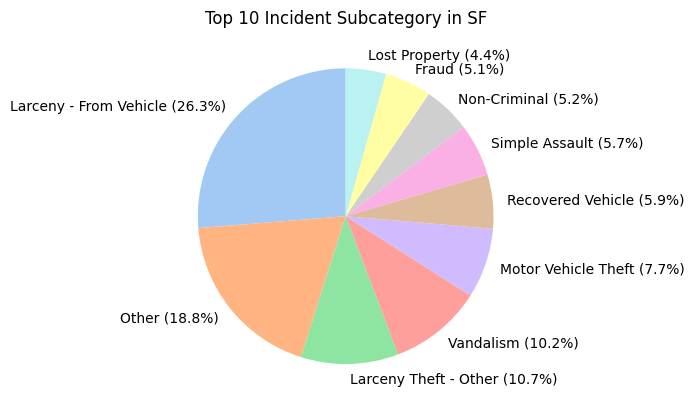

In [35]:

import matplotlib.pyplot as plt

top10 = sfIncidents_s['incident_subcategory'].value_counts().head(10)


colors = sns.color_palette("pastel")

labels = ['{} ({:.1f}%)'.format(label, percentage) for label, percentage in zip(top10.index, top10.values / top10.sum() * 100)]

plt.pie(top10, labels=labels, colors=colors, startangle=90)

plt.title('Top 10 Incident Subcategory in SF')

plt.show()



Ahora vamos a ver un recuento agrupando por incident_code y incident_category

In [36]:
incident_count = sfIncidents_s.groupby(['incident_code', 'incident_category', 'incident_subcategory']).size().reset_index(name='count')
incident_count = pd.DataFrame(incident_count.sort_values(by='count', ascending=False))
print(incident_count.head(10))

        incident_code    incident_category    incident_subcategory  count
830403           6244        Larceny Theft  Larceny - From Vehicle  90769
2446483         28150   Malicious Mischief               Vandalism  23844
451712           4134              Assault          Simple Assault  21176
2901492         71000        Lost Property           Lost Property  20827
1025545          7041    Recovered Vehicle       Recovered Vehicle  20310
936246           6372        Larceny Theft   Larceny Theft - Other  20220
1000193          7021  Motor Vehicle Theft     Motor Vehicle Theft  19657
943302           6374        Larceny Theft   Larceny Theft - Other  17137
2757284         64020         Non-Criminal                   Other  15785
795123           6224        Larceny Theft  Larceny - From Vehicle  13686


A partir de estos datos vemos que los incidnetes más recurrentes son:

- Incidente 830403 (Robo de objetos) - Categoría: Larceny Theft (Robo de objetos) - Subcategoría: Larceny - From Vehicle (Robo de objetos de vehículo) - Recuento: 90769. Los robos de objetos de vehículos representan una preocupación significativa en San Francisco, siendo uno de los incidentes más frecuentes identificados en los datos analizados.

- Incidente 2446483 (Daño intencional) - Categoría: Malicious Mischief (Daño intencional) - Subcategoría: Vandalism (Vandalismo) - Recuento: 23844. Los actos de vandalismo constituyen otro problema recurrente en la ciudad, lo cual ha sido evidenciado por el elevado número de casos registrados.

- Incidente 451712 (Agresión) - Categoría: Assault (Agresión) - Subcategoría: Simple Assault (Agresión simple) - Recuento: 21176. Los incidentes de agresión de menor gravedad se encuentran entre los eventos más comunes, indicando una preocupación en términos de seguridad pública.

- Incidente 2901492 (Propiedad perdida) - Categoría: Lost Property (Propiedad perdida) - Subcategoría: Lost Property (Propiedad perdida) - Recuento: 20827. La pérdida de objetos personales constituye una incidencia frecuente en San Francisco, generando la necesidad de acciones preventivas y de educación para fomentar la responsabilidad en el cuidado de las pertenencias.

En general, se observa una frecuencia notable en ciertos tipos de incidentes. Los incidentes más recurrentes son el robo de objetos de vehículos, el vandalismo, la agresión de menor gravedad y la pérdida de propiedad. 




A continuación vamos a visualizar de forma gráfica las 5 categorías más presentes en nuestros datos y para categoría las dos categorías más destacadas.

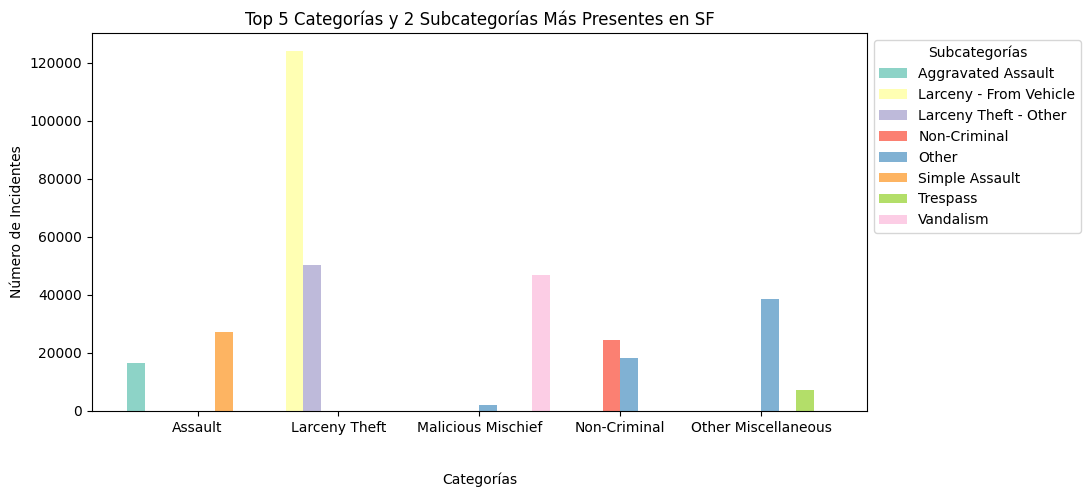

In [37]:
import pandas as pd
import matplotlib.pyplot as plt


top5_categories = sfIncidents_s['incident_category'].value_counts().head(5).index.tolist()

top2_subcategories = []
for category in top5_categories:
    top2_subcategories.extend(sfIncidents_s[sfIncidents_s['incident_category'] == category]['incident_subcategory'].value_counts().head(2).index.tolist())

filtered_data = sfIncidents_s[(sfIncidents_s['incident_category'].isin(top5_categories)) & (sfIncidents_s['incident_subcategory'].isin(top2_subcategories))]


counts = pd.crosstab(filtered_data['incident_category'], filtered_data['incident_subcategory'])


fig, ax = plt.subplots(figsize=(10, 6))
colors = sns.color_palette("Set3", len(counts.columns))
counts.plot(kind='bar', stacked=False, width=1, ax=ax, color=colors)


plt.title('Top 5 Categorías y 2 Subcategorías Más Presentes en SF')
plt.legend(title='Subcategorías', bbox_to_anchor=(1, 1), loc='upper left')


ax.set_xlabel('Categorías')
ax.set_ylabel('Número de Incidentes')


plt.subplots_adjust(bottom=0.25)
x_ticks_labels = [f'{category}\n\n' for category in counts.index]
x_positions = [i for i in range(len(counts.index))]
plt.xticks(x_positions, x_ticks_labels, rotation=0, ha='center')

plt.show()


A partir del gráfico anterior podemos ver de forma más visual los resultados obtenidos a partir del recuento de valores realizado anteriormente.

En resumen del análisis exploratorio de las categorías y subcategorías de los incidentes podemos destacar que:

Observamos que  las categorías y subcategorías más frecuentes de los incidentes registrados en San Francisco. La categoría "Larceny Theft" y la subcategoría "Larceny - From Vehicle" encabezan la lista con un recuento de 124053, seguido de "Larceny Theft - Other" con un recuento de 50380. La tercera categoría más frecuente es "Malicious Mischief" con la subcategoría "Vandalism" con un recuento de 46628.
Otros incidentes comunes incluyen "Other Miscellaneous" con la subcategoría "Other" y "Trespass"
- Larceny Theft: Robo menor
- Larceny - From Vehicle: Robo menor - De un vehículo
- Larceny Theft - Other: Robo menor - Otros
- Malicious Mischief: Daño malintencionado
- Vandalism: Vandalismo
- Other Miscellaneous: Otros incidentes varios

Estudio de anómalos y atípicos para las variables incident_code, incident_category e incident_subactegory

Para hacer este estudio de datos anómalos y atípicos emplearemos un conjunto de datos publicado por el Departamento de Policía de San Francisco en el que se recogen para cada incident_code, la variable incident_category e incident_subcategory. La descarga de este archivo se puede visualizar en el documento  "ACTA 1. Obtención y extracción de los datos".
A partir de este conjunto de datos comprobaremos que en cada registro tenemos una tupla incident_code, incident_category e incident_subcategory que está presente en el conjunto de datos descargado. 

Comenzamos cargando el conjunto de datos. 

In [38]:
df_codes = pd.read_csv('Reference__Police_Department_Incident_Code.csv')
print(df_codes.head())


   INC_CODE  CATEGORY SUBCATEGORY
0      1000  homicide    homicide
1      1001  homicide    homicide
2      1002  homicide    homicide
3      1003  homicide    homicide
4      1004  homicide    homicide


Como vemos en el conjunto descargado tenemos tanto la categoría como la subcategoría están en minúscula por lo que tendremos que convertir en minúscula nuestras variables. 

In [39]:
sfIncidents_s['incident_category'] = sfIncidents_s['incident_category'].str.lower()
sfIncidents_s['incident_subcategory'] = sfIncidents_s['incident_subcategory'].str.lower()


Tras esta conversión vamos a proceder a buscar cada tupla incident_code, incident_category e incident_subcategory de nuestro conjunto de datos en los códigos válidos publicados por los cuerpos de seguridad de San Francisco. 

In [40]:
valid_rows = sfIncidents_s[['incident_code', 'incident_category', 'incident_subcategory']].isin(df_codes[['INC_CODE', 'CATEGORY', 'SUBCATEGORY']].values.flatten()).all(axis=1)

invalid_rows = sfIncidents_s[~valid_rows]

print(invalid_rows.shape)


(615, 9)


Tenemos 615 registros en los que no coincide esta tupla, vamos a hacer un recuento de nuestras variables para estos casos para ver qué puede estar pasando 

In [41]:
category = invalid_rows.groupby(['incident_code', 'incident_category', 'incident_subcategory']).size().reset_index(name='count')
print(category)

Empty DataFrame
Columns: [incident_code, incident_category, incident_subcategory, count]
Index: []


No ha sido posible agrupar los datos por algún problema en los datos, vamos a revisar los primeros 5 registros para averiguar qué ocurre. 

In [42]:
print(invalid_rows.head())

         incident_datetime incident_day_of_week incident_code   
35850  2018-02-09 10:17:00               Friday         12075  \
328773 2018-02-09 10:17:00               Friday         12075   
337535 2018-02-24 10:00:00             Saturday         12075   
233638 2018-03-07 16:48:00            Wednesday         12075   
267461 2018-03-13 10:07:00              Tuesday         12075   

       incident_category incident_subcategory incident_description   
35850                NaN                  NaN   Military Ordinance  \
328773               NaN                  NaN   Military Ordinance   
337535               NaN                  NaN   Military Ordinance   
233638               NaN                  NaN   Military Ordinance   
267461               NaN                  NaN   Military Ordinance   

            resolution   latitude   longitude  
35850   Open or Active  37.762342 -122.450737  
328773  Open or Active  37.762342 -122.450737  
337535       Unfounded  37.764898 -122.40063

Observamos que los valores de incident_category y incident_subcategory son nulos, vamos a hacer recuento de nulos por estas dos variables y ver si todos los casos en los que las tuplas no han coincidido con los códigos válidos son casos de nulos.

In [43]:
null_cat= invalid_rows['incident_category'].isnull().sum()
null_subcat = invalid_rows['incident_subcategory'].isnull().sum()
print('Nulos por incident_category : ' + str(null_cat))
print('Nulos por incident_subcategory : ' + str(null_subcat))

Nulos por incident_category : 615
Nulos por incident_subcategory : 615


Hemos comprobado que todos los casos en los que no ha coincidido la tupla son casos de nulos. 
Por el momento no vamos a realizar ningún tratamiento para los valores nulos hasta terminar el análisis exploratorio. 

Finalmente vamos a convertir a mayúsculas nuestras variables incident_category e incident_subcategory. 

In [44]:
sfIncidents_s['incident_category'] = sfIncidents_s['incident_category'].str.upper()
sfIncidents_s['incident_subcategory'] = sfIncidents_s['incident_subcategory'].str.upper()

2. Análisis de la variable incident_description

Comenzamos con un recuento de los distintos valores que puede tomar esta variable para asegurarnos de que no es un campo libre y que podemos analizarlo y buscar relaciones con otras variables. 

In [45]:
print(sfIncidents_s['incident_description'].value_counts())

incident_description
Theft, From Locked Vehicle, >$950                   90769
Malicious Mischief, Vandalism to Property           23844
Battery                                             21176
Lost Property                                       20827
Vehicle, Recovered, Auto                            20310
                                                    ...  
Sale or Manufacture of Deceptive ID                     1
Sale of Satellite Telephone Numbers                     1
Robbery, Vehicle for Hire, Att., W/ Other Weapon        1
Robbery, Vehicle for Hire, Att., W/ Gun                 1
Wiretaps, Unauthorized                                  1
Name: count, Length: 840, dtype: int64


Mostramos aquellos valores que sólo están una vez.

In [46]:
counts = sfIncidents_s['incident_description'].value_counts()
unique_counts = counts[counts == 1]
print(unique_counts)

incident_description
Accidental Burns                                     1
Assault, By Police Officers                          1
Advertisements, Affixing To Poles                    1
Weapon, Deadly, Possession of to Violate 136.1 PC    1
Assault or Attempted Murder Upon Gov't Officers      1
                                                    ..
Sale or Manufacture of Deceptive ID                  1
Sale of Satellite Telephone Numbers                  1
Robbery, Vehicle for Hire, Att., W/ Other Weapon     1
Robbery, Vehicle for Hire, Att., W/ Gun              1
Wiretaps, Unauthorized                               1
Name: count, Length: 76, dtype: int64


Vemos que parece ser que no es un campo libre ya que hay varios registros que cuentan con la misma descripción, pero en la ficha de OpenDataSF parece que es un campo libre. 

Voy a proceder a eliminar esta variable ya que según la plataforma es un campo libre, vemos que si que hay descripciones que se repiten pero hay otras que no. Este campo podría introducir bastante ruido a nuestro modelo porque hay un desbalance de clases por lo que eliminamos la variable  

In [47]:
sfIncidents_s = sfIncidents_s.drop('incident_description', axis=1)

3. Análisis de la variable resolution

Comenzaremos con una descripción de los posibles valores que puede tomar esta variable. 

La variable "resolution" en el conjunto de datos de incidentes de San Francisco describe el resultado final de la investigación del incidente. A continuación se presentan las descripciones de los diferentes valores que puede tomar:
- NONE: No se ha tomado ninguna medida para resolver el incidente.
- OPEN OR ACTIVE: El incidente está en curso y aún no se ha resuelto.
- ARREST, BOOKED: Se realizó un arresto y el sospechoso fue detenido y fichado.
- ARREST, CITED: El sospechoso fue citado y liberado, pero se espera que se presente en la corte en una fecha posterior.
- CITE OR ARREST ADULT: El sospechoso fue detenido y liberado después de ser citado y acusado formalmente de un delito.
- PSYCHOPATHIC CASE: El incidente involucró a una persona con trastornos mentales y se tomó medidas para garantizar su seguridad y la de los demás.
- UNFOUNDED: Se determinó que el incidente no ocurrió como se informó inicialmente.
- LOCATED: La persona o propiedad perdida o robada fue encontrada.
- COMPLAINANT REFUSES TO PROSECUTE: El denunciante se negó a presentar cargos contra el sospechoso.
- NOT PROSECUTED: El sospechoso fue arrestado, pero no se presentaron cargos contra él.
- DISTRICT ATTORNEY REFUSES TO PROSECUTE: El fiscal de distrito se negó a presentar cargos contra el sospechoso.
- PROSECUTED BY OUTSIDE AGENCY: El sospechoso fue arrestado y acusado de un delito por una agencia policial diferente.
- EXCEPTIONAL CLEARANCE: Se resolvió el incidente, pero no se realizó ningún arresto.
- UNFOUNDED: Se determinó que el incidente no ocurrió como se informó inicialmente (en minúsculas).
- EXCEPTIONAL ADULT: Un caso en el que un adulto es sospechoso de cometer un delito sexual y la víctima tiene menos de 18 años.
- PROSECUTED FOR LESSER OFFENSE: El sospechoso fue arrestado y acusado de un delito menor.

Hacemos un recuento para visualizar la distribución de la variable.

In [48]:
print(sfIncidents_s['resolution'].value_counts())

resolution
Open or Active          573816
Cite or Arrest Adult    137439
Unfounded                 3816
Exceptional Adult         1849
Name: count, dtype: int64


El resultado del recuento indica la cantidad de incidentes que corresponden a cada descripción de incidente (incident_description). La descripción "NONE" es la más común, con 1362758 incidentes, seguida de "Open or Active" con 558762 incidentes. Las descripciones que indican la detención de un sospechoso, como "ARREST, BOOKED" y "ARREST, CITED", tienen un alto número de incidentes, con 509111 y 153363, respectivamente. También hay descripciones que indican la resolución de un caso sin necesidad de presentar cargos, como "UNFOUNDED" y "EXCEPTIONAL CLEARANCE", con 22779 y 3976 incidentes, respectivamente. Por último, hay descripciones que indican que no se presentaron cargos, como "NOT PROSECUTED" y "DISTRICT ATTORNEY REFUSES TO PROSECUTE", con 7556 y 7122 incidentes, respectivamente.

Ahora realizaremos un histograma para visualizar la información anterior de formamás gráfica.

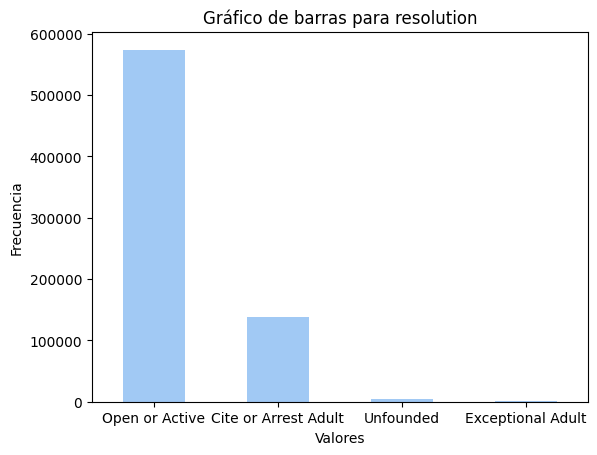

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt

columna_categorica = sfIncidents_s['resolution']
conteo_valores = columna_categorica.value_counts()

sns.set_palette("pastel")

fig, ax = plt.subplots()
conteo_valores.plot(kind='bar', ax=ax)

ax.set_title('Recuento de incidentes por resolución')
ax.set_xlabel('Resolution')
ax.set_ylabel('Recuento')

ax.set_xticklabels(conteo_valores.index, rotation=0)

plt.show()


## Análisis valores faltantes<a name="Análisis-valores-faltantes"></a>

Análisis NA's

A continuación trataremos de hacer un estudio sobre los datos faltantes de nuestro conjunto de datos. Para este estudio seguiremos los siguientes pasos:
1. Recuento de valores NA's por variable y por fila. 
2. Análisis del tipo de patrón de estos NA's
3. Tratamiento de valores faltantes

1. Recuento de valores NA's por variable y por fila

Comenzamos realizando un recuento de valores faltante por columna incluyendo la proporción que representan sobre nuestros datos. 

In [50]:
for column in sfIncidents_s.columns:
    null_count = sfIncidents_s[column].isnull().sum()
    percent_null = null_count / len(sfIncidents_s) * 100
    print(f"{column}: {null_count} ({percent_null:.2f}%)")



incident_datetime: 0 (0.00%)
incident_day_of_week: 0 (0.00%)
incident_code: 0 (0.00%)
incident_category: 616 (0.09%)
incident_subcategory: 616 (0.09%)
resolution: 0 (0.00%)
latitude: 38192 (5.33%)
longitude: 38192 (5.33%)


Observamos que tenemos valores faltantes en las variables incident_category, incident_subcategory, latitud y longitud. 
Vemos también que los porcentajes de valores NA's en estas variables son muy pequeños. 

A continuación pasamos a analizar cuántos nulos tenemos por fila y un recuento de número de faltantes por fila

In [51]:

num_null_rows = sfIncidents_s.isnull().sum(axis=1).value_counts().sort_index()
print(num_null_rows)

0    678125
2     38782
4        13
Name: count, dtype: int64


Contemplamos que tenemos 678125 casos completos, 38782 registros con 2 valores faltantes y 13 registros con 2 valores faltantes.

2. Análisis del tipo de patrón de estos NA's

Para estudiar el tipo de patrón existente en nuestros valores faltantes realizaremos un mapa de calor mediante la librería seaborn para ver si detectamos de forma gráfica la existencia de una relación entre los valores faltantes y nuestras variables.

<Axes: >

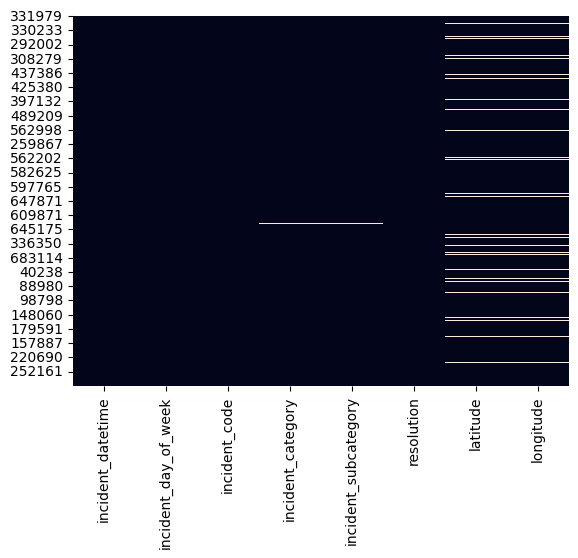

In [52]:
sns.heatmap(sfIncidents_s.isnull(), cbar=False)

Vemos que sólo se observan los NA's para la latitud y la longitud y no podemos analizar el patrón de estos faltantes con las variables incident_category e incident_category ya que el conjunto es muy grande y la proporción de NA's en estas últimas variables es muy pequeña. 

Con el fin de analizar mejor este patrón vamos a seleccionar un subconjunto de datos con aquellos registros en los que tengamos faltantes.

<Axes: >

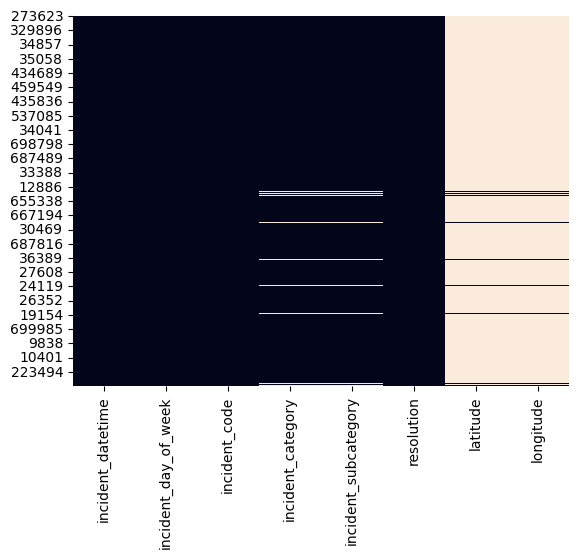

In [53]:

null_rows = sfIncidents_s[sfIncidents_s.isnull().any(axis=1)]
sns.heatmap(null_rows.isnull(), cbar=False)


Tras haber visto este dos gráficos anteriores podemos concluir que el patrón de los valores faltantes en nuestros datos es completamente aleatorio. 

3. Tratamiento de valores nulos

Una vez hemos detectado que la presencia de los valores nulos en nuestros datos es debida a un patrón aleatorio y que la proporción de registros con valores faltantes es muy pequeña ya que tenemos un conjunto de datos muy grande por ello vamos a proceder a eliminar todos los registros con valores faltantes. 

In [54]:
sfIncidents_c = sfIncidents_s.dropna()
print(sfIncidents_c.shape)
print(sfIncidents_c.columns)


(678125, 8)
Index(['incident_datetime', 'incident_day_of_week', 'incident_code',
       'incident_category', 'incident_subcategory', 'resolution', 'latitude',
       'longitude'],
      dtype='object')


Tras haber elimindo los registros con valores nulos hemos obtenido un conjunto de datos final con 678125 registros y 8 columnas. 
Guardamos y exportamos nuestro dataframe para usarlo posteriormente. 

In [55]:
sfIncidents_c.to_csv('Incidents_Clean.csv',header=True, index = False)